In [60]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplfinance as mpf
from scipy.fft import fft, fftfreq
#mpl.rcParams['figure.figsize'] = (10, 5)
mpl.rcParams['axes.grid'] = False

## Functions

In [61]:
def safely_mkdir(dirPath:str):
    '''安全地生成目錄，若目錄已存在則無動作'''
    if os.path.exists(dirPath):
        print("Directory is exist.")
    os.makedirs(dirPath, exist_ok=True) 
    return dirPath

In [62]:
def MyFFT(fftInput, hamming, T):
    '''快速傅立葉變換'''
    if hamming:
        fftInput = fftInput * np.hamming(len(fftInput)) # hamming窗函數，減少頻率洩漏

    N = len(fftInput) # Number of sample points
    # T = 1.0 / 9.0 # sample spacing # 應使用傳入值T
    ## x = np.linspace(0.0, N*T, N, endpoint=False)
    y = fftInput
    yf = fft(y)
    xf = fftfreq(N, T)[:N//2]

    yf_regular = 2.0/N * np.abs(yf[0:N//2])


    return xf, yf_regular #*1.85 #漢明窗振幅補償

In [63]:
def visualize_candlestick_ver1(df, show_day:np.array):
    '''show raw data candlestick
    顏色採台灣股市風格：紅色表示漲, 綠色表示跌
    資料視覺化: Ref.: https://towardsdatascience.com/basics-of-ohlc-charts-with-pythons-matplotlib-56d0e745a5be
    Paremeter:
    * df: DataFrame (須包含 open, close, high, low)
    * show_day: array, [開始日:int, 結束日:int]
    '''
    x = np.arange(0,len(df[show_day[0]:show_day[1]]))
    fig, ax = plt.subplots(1, figsize=(12,4))

    for idx, val in df[show_day[0]:show_day[1]].iterrows():   
        color = ('red' if val['open'] > val['close'] else 'green')
        # high/low lines
        plt.plot([x[idx], x[idx]], 
                [val['low'], val['high']], 
                color='black')
        # open marker
        plt.plot([x[idx], x[idx]-0.1], 
                [val['open'], val['open']], 
                color=color)
        # close marker
        plt.plot([x[idx], x[idx]+0.1], 
                [val['close'], val['close']], 
                color=color)

    # ticks: date
    #plt.xticks(x[::3], df_apple.date.dt.date[::3])
    ax.set_xticks(x, minor=True) # apply to every ticks

    # labels
    plt.ylabel('USD')

    # grid
    ax.xaxis.grid(color='black', linestyle='dashed', which='both', alpha=0.1)

    # remove spines
    #ax.spines['right'].set_visible(False)
    #ax.spines['top'].set_visible(False)

    # title
    plt.title('IBM Stock Price', loc='left', fontsize=20)

    plt.show()

In [64]:
def visualize_candlestick_ver2(df=None, type='candle', mav=[5], show_day=None):
    '''Use mpf package to show candlestick
    K 線圖 (Candlestick Chart)
    均線: moving averages with the mav keyword, [5日均線]
    ---
    Paremter:
    * df: DataFrame (須包含 open, close, high, low)
    * type: 顯示模式
    * mav: 均線
    * show_day: array, [開始日:int, 結束日:int]
    '''
    df = df.copy()
    df.index = pd.to_datetime(df.index, unit="D")
    mpf.plot(df[show_day[0]:show_day[1]], type=type, mav=mav, datetime_format='%b %d')
    print("因資料集無法獲得確切時間，因此 x 軸並非真實日期")

## Import Data and Preprocessing
* 可以假設助教測試時的 Training 與 Testing data 時間會接續，因此不必自己處理爬蟲及資料時間有斷開的問題

In [65]:
# import raw data
training_data = "training_data.csv" #load_data(args.training)
testing_data = "testing_data.csv" #load_data(args.testing)
raw_train_df = pd.read_csv(training_data, header=None)
raw_test_df = pd.read_csv(testing_data, header=None)

In [66]:
# 欄位重新命名
raw_train_df.rename(columns={0:'open', 1:'high', 2:'low', 3:'close'}, inplace=True)
raw_test_df.rename(columns={0:'open', 1:'high', 2:'low', 3:'close'}, inplace=True)
print(f"Data counts: {len(raw_train_df)}\n", raw_train_df, '\n') 
print(f"Data counts: {len(raw_test_df)}\n", raw_test_df)

Data counts: 1488
         open    high     low   close
0     186.73  188.71  186.00  186.30
1     185.57  186.33  184.94  185.54
2     184.81  185.03  183.10  184.66
3     184.39  184.48  182.31  182.54
4     182.20  182.27  180.27  181.59
...      ...     ...     ...     ...
1483  151.95  152.20  151.33  151.84
1484  152.06  152.49  151.62  151.98
1485  152.35  152.93  151.70  152.47
1486  152.81  153.61  152.17  153.55
1487  153.65  154.41  153.08  153.97

[1488 rows x 4 columns] 

Data counts: 20
       open    high     low   close
0   154.40  155.02  152.91  154.76
1   155.96  156.80  155.07  156.46
2   156.45  156.74  154.68  155.35
3   154.10  156.22  154.09  154.10
4   153.59  154.45  153.26  153.57
5   154.81  155.03  153.55  154.81
6   155.46  155.89  154.57  155.41
7   156.74  157.85  155.16  156.74
8   156.60  156.73  153.89  153.91
9   154.60  155.11  153.70  154.00
10  153.61  153.80  152.03  152.50
11  153.59  154.18  153.21  153.33
12  154.05  154.17  153.09  153.23
13 

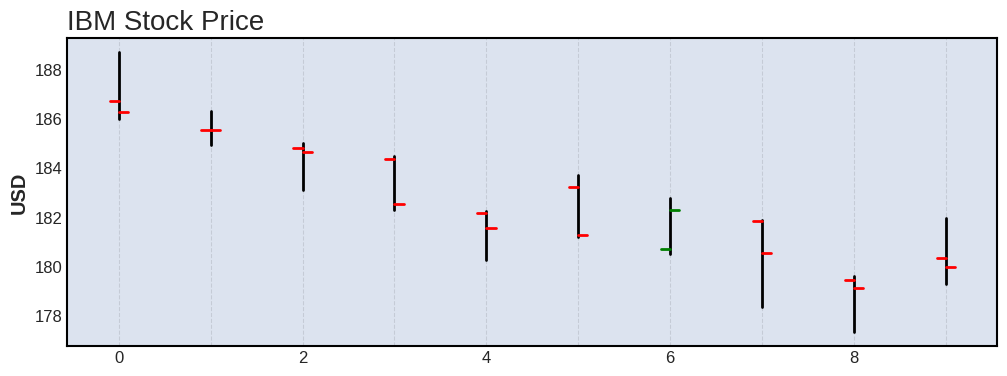

In [67]:
# show raw data candlestick (自製：顯示前十天的)
visualize_candlestick_ver1(raw_train_df, show_day=[0,10])

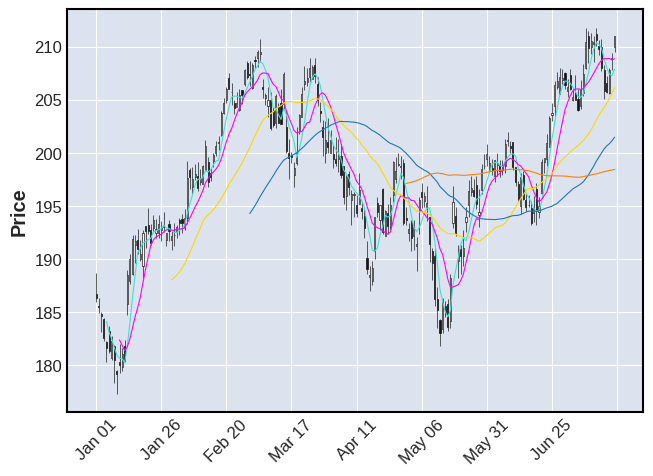

因資料集無法獲得確切時間，因此 x 軸並非真實日期


In [68]:
# K 線圖 (Candlestick Chart)
# Use mpf package to show candlestick
# 均線: moving averages with the mav keyword, [5日均線, 10日均線, 30日均線, 60日均線, 120日均線]
visualize_candlestick_ver2(raw_train_df, type='candle', mav=[5,10,30,60,120], show_day=[0,200])

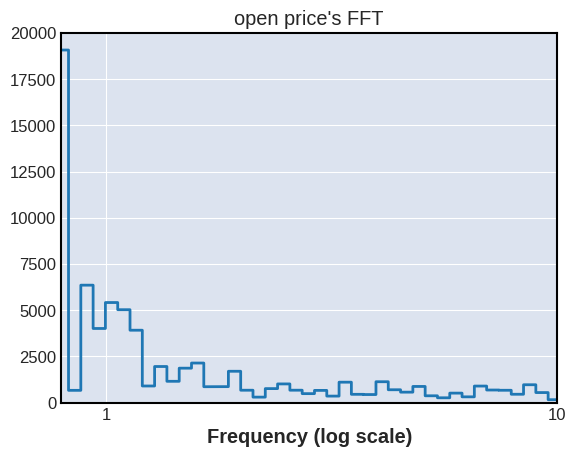

In [69]:
# 視覺化：將時域轉成頻域
fft = tf.signal.rfft(raw_train_df['open'])
f_per_dataset = np.arange(0, len(fft))

n_samples_d = len(raw_train_df['open'])
days_per_year = 365.2425
years_per_dataset = n_samples_d/(days_per_year)
f_per_year = f_per_dataset/years_per_dataset

plt.title("open price's FFT")
plt.step(f_per_year, np.abs(fft))
#plt.xscale('log')
plt.ylim(0, 20000)
plt.xlim([0.1, 10])
plt.tick_params(width=5)
plt.xticks([1, 10]) # labels=['a','b']
_ = plt.xlabel('Frequency (log scale)')

### MOVING AVERAGE 
https://www.geeksforgeeks.org/how-to-calculate-moving-average-in-a-pandas-dataframe/

In [70]:
# Add MOVING AVERAGE Columns (計算日均值)
raw_train_df['open-MA 5 days'] = raw_train_df['open'].rolling(5).mean()
raw_train_df['open-MA 10 days'] = raw_train_df['open'].rolling(10).mean()
raw_train_df['open-MA 30 days'] = raw_train_df['open'].rolling(30).mean()
raw_train_df['open-MA 60 days'] = raw_train_df['open'].rolling(60).mean()
raw_train_df['open-MA 120 days'] = raw_train_df['open'].rolling(120).mean()

raw_train_df['close-MA 5 days'] = raw_train_df['close'].rolling(5).mean()
raw_train_df['close-MA 10 days'] = raw_train_df['close'].rolling(10).mean()
raw_train_df['close-MA 30 days'] = raw_train_df['close'].rolling(30).mean()
raw_train_df['close-MA 60 days'] = raw_train_df['close'].rolling(60).mean()
raw_train_df['close-MA 120 days'] = raw_train_df['close'].rolling(120).mean()
  
# 移除最前面計算平均時, 因天數不足導致 MA 欄位為 NaN 的資料 
# Removing all the NULL values using dropna() method
raw_train_df.dropna(inplace=True)
  
# printing Dataframe
raw_train_df

,open,high,low,close,open-MA 5 days,open-MA 10 days,open-MA 30 days,open-MA 60 days,open-MA 120 days,close-MA 5 days,close-MA 10 days,close-MA 30 days,close-MA 60 days,close-MA 120 days
119,193.87,194.88,193.22,193.70,197.608,196.022,195.611000,199.944667,196.971583,196.618,195.745,195.532333,199.962833,197.122750
120,192.48,193.39,191.68,192.86,196.590,195.610,195.361667,199.717833,197.019500,195.532,195.780,195.255333,199.706000,197.177417
121,193.54,193.68,190.75,191.95,195.532,195.750,195.149000,199.464500,197.085917,194.136,195.520,195.005667,199.427667,197.230833
122,192.14,193.70,190.90,193.00,194.220,195.528,194.905667,199.184167,197.147000,192.980,195.510,194.804333,199.153167,197.300333
123,191.23,192.08,188.90,191.40,192.652,195.351,194.632667,198.882833,197.204000,192.582,195.140,194.526667,198.851500,197.374167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1483,151.95,152.20,151.33,151.84,151.046,149.844,152.626000,149.022167,148.928417,151.008,149.771,152.277667,148.879000,148.799417
1484,152.06,152.49,151.62,151.98,151.590,149.985,152.778667,149.172833,148.928917,151.610,150.053,152.440333,149.028167,148.796167
1485,152.35,152.93,151.70,152.47,151.932,150.332,152.949667,149.329000,148.923083,152.002,150.460,152.628333,149.168000,148.808583
1486,152.81,153.61,152.17,153.55,152.234,150.818,153.155667,149.484167,148.938167,152.322,150.926,152.862000,149.343167,148.820667


開盤價的 MOVING AVERAGE 示意圖


<AxesSubplot:>

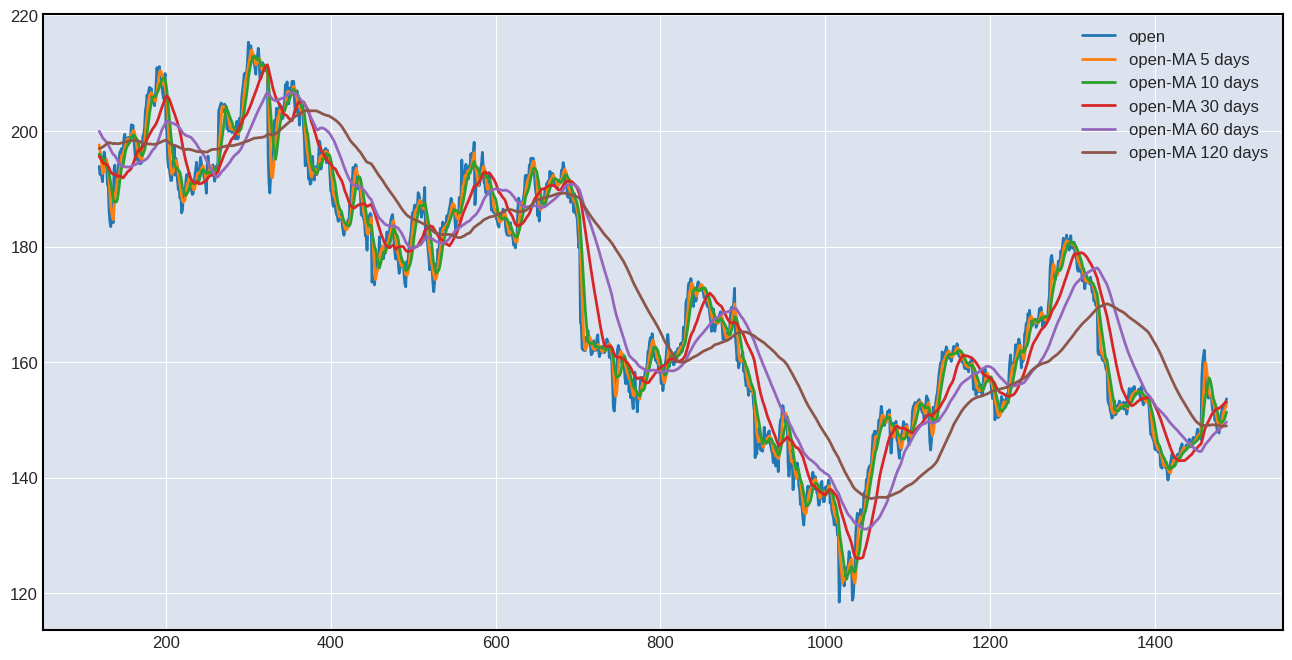

In [71]:
# 開盤價的 MOVING AVERAGE 示意圖 (Plotting Open Price and Simple)
# moving average of 30 days using .plot() method
print("開盤價的 MOVING AVERAGE 示意圖")
raw_train_df[['open', 'open-MA 5 days', 'open-MA 10 days', 'open-MA 30 days', 'open-MA 60 days', 'open-MA 120 days']].plot(
              label='RELIANCE', figsize=(16, 8), style='-')

收盤價的 MOVING AVERAGE 示意圖


<AxesSubplot:>

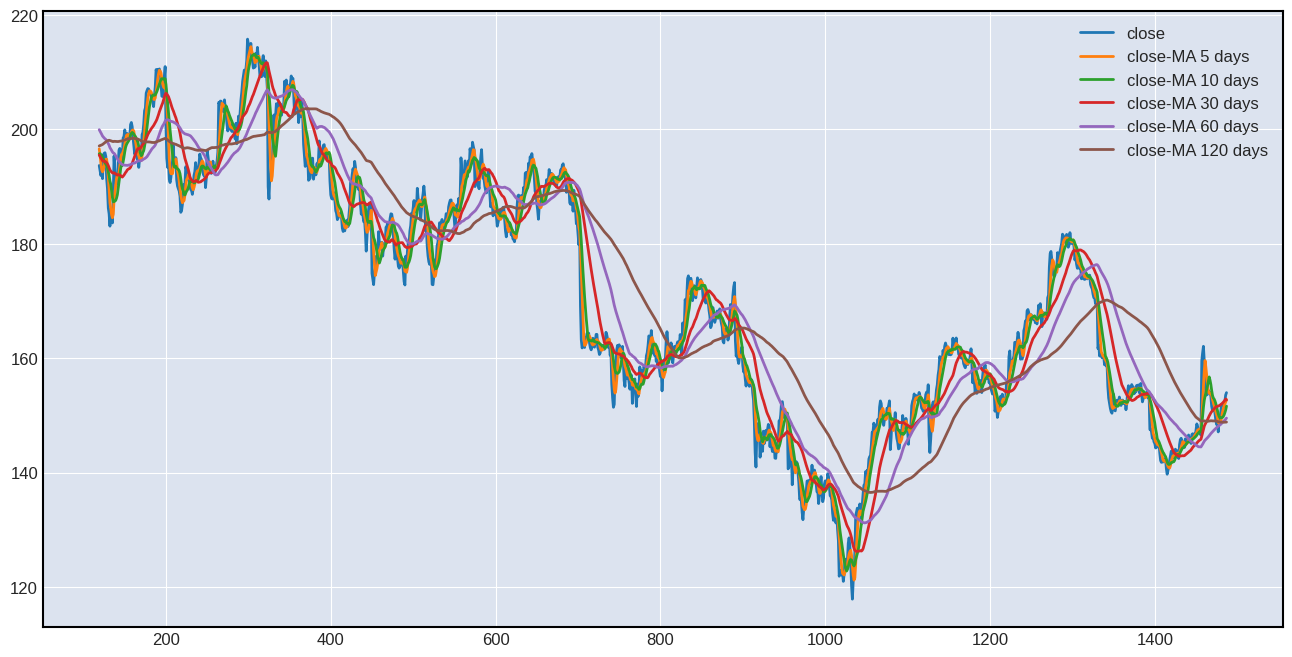

In [72]:
# 收盤價的 MOVING AVERAGE 示意圖 (Plotting Close Price and Simple)
# moving average of 30 days using .plot() method
print("收盤價的 MOVING AVERAGE 示意圖")
raw_train_df[['close', 'close-MA 5 days', 'close-MA 10 days', 'close-MA 30 days', 'close-MA 60 days', 'close-MA 120 days']].plot(
              label='RELIANCE', figsize=(16, 8), style='-')

## Make Dataset

In [73]:
def GenerateDataset(Raw_Data_df:pd.DataFrame, 
                    offset:int, num_features:int, columns_to_be_label:list, predict_num_days:int,
                    Generated_dataset_dict:dict, NewAppendData:pd.core.series.Series,
                    print_explain:bool):
    '''功能 1: 產生新的盛裝 Numpy 資料集 (用 dict 成裝, 訓練集或測試集都可製作)
    功能 2: 當輸入『現有的 numpy 資料集』及『(預測結束後) 當天的原始資料』，就能製作一筆新的 numpy 資料並 append 至現有的 numpy 資料集
    ---
    Paremeters:
    * 功能 1:
      * Raw_Data_df (DataFrame): 原始 pandas df 資料表
      * offset (int): 用於產生 input x, offset 即 lstm 的 steps,表示欲製作的 numpy 資料集，要往前看幾天份的資料 （往前看 offset 天）
      * num_features (int): 用於產生 input x, 特徵數量
      * columns_to_be_label (list of str): 用於產生 label y, 此為原始 pandas df 資料表中要選作為 label 的「欄位名稱」
      * predict_num_days (int): 預測未來幾天
    * 功能 2 (只會於 model inference 之後使用):
      * Generated_dataset_dict (dict of numpy array): 昨天產生的 numpy 資料集
      * NewAppendData (one sample of pd.DataFrame): 今天收盤後的「今日資料」, 用於產生新的 numpy 資料集
    * print_explain (bool): 是否要印出解釋數據？
    ---
    Returns: 
    * NumpyDataset_dict (dict of numpy arrays): 新的 Numpu Dataset
    * 新的 raw data pandas 資料表 (若使用功能 2, 此表會新增一筆資料)
    '''
    # 初始化: Numpy 資料集
    NumpyDataset_dict = {'x':np.empty(shape=(0,offset,num_features)), 'y':np.empty(shape=(0,2*predict_num_days,1))}
    # 逐筆製作 numpy 資料並 append 至 Numpy 資料集
    for date in range(len(Raw_Data_df)-offset-predict_num_days):
      # 製作一筆 x data: 每 offset 天的 features 製作成一筆 x data
      one_sample_x_np = Raw_Data_df[date:date+offset].to_numpy()
      NumpyDataset_dict['x'] = np.append(NumpyDataset_dict['x'], one_sample_x_np[np.newaxis,:], axis=0)
      # 製作一筆 y data: 將未來的？天的開盤價及收盤價製作成一筆 y data
      # 初始化: y data 
      one_sample_y_np = np.empty(shape=(0, 1))
      for future_date in range(predict_num_days):
        # 依欲預測的未來天數, 逐日取出 label data
        one_sample_y_np = np.append(one_sample_y_np, Raw_Data_df[columns_to_be_label].iloc[date+offset+future_date].to_numpy()[:,np.newaxis], axis=0)
      NumpyDataset_dict['y'] = np.append(NumpyDataset_dict['y'], one_sample_y_np[np.newaxis,:], axis=0)
    
    if print_explain:
      print(f"資料集 x shpae = {NumpyDataset_dict['x'].shape}:\n" \
            f"{NumpyDataset_dict['x'].shape[0]} samples(資料筆數),\n" \
            f"{NumpyDataset_dict['x'].shape[1]} steps({offset}天),\n" \
            f"{NumpyDataset_dict['x'].shape[2]} features(特徵數量)\n")
      print(f"資料集 y shpae = {NumpyDataset_dict['y'].shape}:\n" \
            f"{NumpyDataset_dict['y'].shape[0]} samples(資料筆數),\n" \
            f"{NumpyDataset_dict['y'].shape[1]} labels(特徵數量) 0:明天開盤價, 1:明天收盤價, 依此類推\n" \
            f"{NumpyDataset_dict['y'].shape[2]} (開盤價/收盤價)")

    return NumpyDataset_dict


### Traning Set (dict of numpy arrays)

In [74]:
# [Train_set_1] 往前回推，每 120 天,預測未來 1 天
Train_set_1 = GenerateDataset(raw_train_df,
                      offset=120, num_features=len(raw_train_df.columns), 
                      columns_to_be_label=['open','close'], predict_num_days=1,
                      Generated_dataset_dict=None, NewAppendData=None,
                      print_explain=True)

資料集 x shpae = (1248, 120, 14):
1248 samples(資料筆數),
120 steps(120天),
14 features(特徵數量)

資料集 y shpae = (1248, 2, 1):
1248 samples(資料筆數),
2 labels(特徵數量) 0:明天開盤價, 1:明天收盤價, 依此類推
1 (開盤價/收盤價)


In [75]:
# [Train_set_2] 往前回推，每 120 天,預測未來 1 天
Train_set_2 = GenerateDataset(raw_train_df,
                      offset=120, num_features=len(raw_train_df.columns), 
                      columns_to_be_label=['open','close'], predict_num_days=2,
                      Generated_dataset_dict=None, NewAppendData=None,
                      print_explain=True)

資料集 x shpae = (1247, 120, 14):
1247 samples(資料筆數),
120 steps(120天),
14 features(特徵數量)

資料集 y shpae = (1247, 4, 1):
1247 samples(資料筆數),
4 labels(特徵數量) 0:明天開盤價, 1:明天收盤價, 依此類推
1 (開盤價/收盤價)


In [76]:
'''
raw_train_df['open-MA 5 days'] = raw_train_df['open'].rolling(5).mean()
raw_train_df['open-MA 10 days'] = raw_train_df['open'].rolling(10).mean()
raw_train_df['open-MA 30 days'] = raw_train_df['open'].rolling(30).mean()
raw_train_df['open-MA 60 days'] = raw_train_df['open'].rolling(60).mean()
raw_train_df['open-MA 120 days'] = raw_train_df['open'].rolling(120).mean()

raw_train_df['close-MA 5 days'] = raw_train_df['close'].rolling(5).mean()
raw_train_df['close-MA 10 days'] = raw_train_df['close'].rolling(10).mean()
raw_train_df['close-MA 30 days'] = raw_train_df['close'].rolling(30).mean()
raw_train_df['close-MA 60 days'] = raw_train_df['close'].rolling(60).mean()
raw_train_df['close-MA 120 days'] = raw_train_df['close'].rolling(120).mean()
'''
print('計算 test data')

計算 test data


## Build Model 

In [86]:
def Build_LSTMModel(input_dims, output_dims, name):
    '''Functional API format: 
    keras functional api is a highly customizable design.
    This is Kuihao's style model builder.'''
    # Define input layer with shape 
    input_layer = tf.keras.Input(shape=input_dims, name='input_layer_lstm') 

    # Construct NN connections
    x = input_layer # apply to input layer
    
    x = tf.keras.layers.GRU(units=20, activation='relu', return_sequences=True, name='lstm_layer_1')(x) # LSTM 可直接換成 GRU
    x = tf.keras.layers.GRU(units=10, activation='relu', return_sequences=False, name='lstm_layer_2')(x)
    
    # Concatenate other NN
    #x = tf.keras.layers.Concatenate()([x])
    
    # apply to outout layer with shape
    output_layer = tf.keras.layers.Dense(output_dims, activation='relu', name='output_layer')(x) 

    return tf.keras.Model(inputs=[input_layer], outputs=[output_layer], name=name)

### Train Model 1 (預測隔天開盤及收盤)

In [87]:
# Create an instance of the model
model_1 = Build_LSTMModel(input_dims=(120,14), output_dims=2, name='Stock_Price_tomorrow')
model_1.summary()

Model: "Stock_Price_tomorrow"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer_lstm (InputLayer [(None, 120, 14)]         0         
_________________________________________________________________
lstm_layer_1 (GRU)           (None, 120, 20)           2160      
_________________________________________________________________
lstm_layer_2 (GRU)           (None, 10)                960       
_________________________________________________________________
output_layer (Dense)         (None, 2)                 22        
Total params: 3,142
Trainable params: 3,142
Non-trainable params: 0
_________________________________________________________________


In [88]:
# 印出模型結構圖 Print out model struct digram
#tf.keras.utils.plot_model(taipower_model, to_file='tmp.png', show_shapes=True, show_layer_names=True, dpi=100)

In [91]:
# optimizer
myAdam =  tf.keras.optimizers.Adam(learning_rate=1e-4,)
RMSE_loss = tf.keras.metrics.RootMeanSquaredError(name='root_mean_squared_error', dtype=None)
model_1.compile(optimizer=myAdam, loss='mse',  metrics=[RMSE_loss])

# Setting early stop
EarlyStopor = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50)

In [92]:
# Training
history = model_1.fit(Train_set_1['x'], # features
                      [Train_set_1['y'][:,0],  # tomorrow open price
                       Train_set_1['y'][:,1]], # tomorrow close price
                      epochs=100,
                      batch_size=32,
                      callbacks=[EarlyStopor]) 

Epoch 1/100
39/39 [==============================] - 1s 18ms/step - loss: 14414.3525 - root_mean_squared_error: 120.0598
Epoch 2/100
39/39 [==============================] - 1s 18ms/step - loss: 14413.9678 - root_mean_squared_error: 120.0582
Epoch 3/100
39/39 [==============================] - 1s 18ms/step - loss: 14413.7432 - root_mean_squared_error: 120.0573
Epoch 4/100
39/39 [==============================] - 1s 19ms/step - loss: 14413.0498 - root_mean_squared_error: 120.0544
Epoch 5/100
39/39 [==============================] - 1s 18ms/step - loss: 14412.7031 - root_mean_squared_error: 120.0529
Epoch 6/100
39/39 [==============================] - 1s 18ms/step - loss: 14412.2979 - root_mean_squared_error: 120.0512
Epoch 7/100
39/39 [==============================] - 1s 19ms/step - loss: 14412.0293 - root_mean_squared_error: 120.0501
Epoch 8/100
39/39 [==============================] - 1s 18ms/step - loss: 14411.6055 - root_mean_squared_error: 120.0483
Epoch 9/100
39/39 [=============

KeyboardInterrupt: 

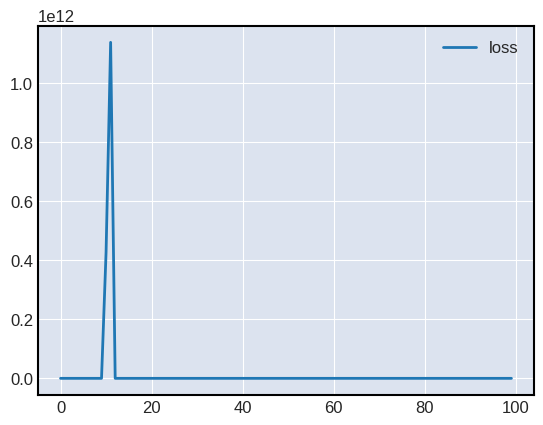

In [93]:
plt.plot(history.history['loss'], label="loss")
plt.legend(loc="upper right")
plt.show()

In [ ]:
# save model
#taipower_model.save('./model/2GRU_DNN_v2_onehot.h5')

array([154.4 , 155.96, 156.45, 154.1 , 153.59, 154.81, 155.46, 156.74,
       156.6 , 154.6 , 153.61, 153.59, 154.05, 153.65, 153.17, 151.82,
       152.51, 152.95, 153.2 , 154.17])

### Train Model 2 (預測明後兩天開盤及收盤)

## Stock Strategy
買賣決策
* 提供參考: [KD指標-KD黃金交叉建議做多-死亡交叉建議做空](https://ithelp.ithome.com.tw/articles/10206894)

## Main

In [ ]:
'''
# You can write code above the if-main block.

if __name__ == "__main__":
    # You should not modify this part.
    import argparse

    parser = argparse.ArgumentParser()
    parser.add_argument("--training", default="training_data.csv", help="input training data file name")
    parser.add_argument("--testing", default="testing_data.csv", help="input testing data file name")
    parser.add_argument("--output", default="output.csv", help="output file name")
    args = parser.parse_args()

    # The following part is an example.
    # You can modify it at will.
    training_data = load_data(args.training)
    trader = Trader()
    trader.train(training_data)

    testing_data = load_data(args.testing)
    with open(args.output, "w") as output_file:
        for row in testing_data:
            # We will perform your action as the open price in the next day.
            action = trader.predict_action(row)
            output_file.write(action)

            # this is your option, you can leave it empty.
            trader.re_training()
'''
print("mute")

mute
